# Пятая неделя


#### Выполнил Ким Антон 
#### В рамках курса "Введение в машинное обучение" от Высшей школы экономики

## I. Размер случайного леса

### Введение
Случайный лес — это модель классификации, объединяющая некоторое количество решающих деревьев в одну композицию, за счет чего улучшается их качество работы и обобщающая способность. Деревья строятся независимо друг от друга. Чтобы они отличались друг от друга, обучение проводится не на всей обучающей выборке, а на ее случайном подмножестве. Также, для дальнейшего уменьшения схожести деревьев, оптимальный признак для разбиения выбирается не из всех возможных признаков, а лишь из их случайного подмножества. Прогнозы, выданные деревьями, объединяются в один ответ путем усреднения.

Особенность случайного леса заключается в том, что он не переобучается по мере увеличения количества деревьев в композиции. Это достигается за счет того, что деревья не зависят друг от друга, и поэтому добавление нового дерева в композицию не усложняет модель, а лишь понижает уровень шума в прогнозах.

### План работы
<ul>
 <li>работать со случайным лесом — одним из наиболее распространенных семейств алгоритмов</li>
 <li>решать с его помощью задачи регрессии</li>
 <li>подбирать параметры случайного леса</li>
</ul>

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

### Загрузка данных 

In [2]:
data = pd.read_csv('data/week_5_abalone.csv')

In [3]:
data.head()

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 277.4+ KB


### Описание данных
Это датасет, в котором требуется предсказать возраст ракушки (число колец) по физическим измерениям


### Инструкции по выполнению
В библиотеке **scikit-learn** случайные леса реализованы в классах `sklearn.ensemble.RandomForestClassifier` (для классификации) и `sklearn.ensemble.RandomForestRegressor` (для регрессии). Обучение модели производится с помощью функции **fit**, построение прогнозов — с помощью функции predict. Число деревьев задается с помощью поля класса **n_estimators**.

Также в этом задании вам понадобится вычислять качество предсказаний на тестовой выборке. Мы будем пользоваться метрикой **R2** — по сути, это среднеквадратичная ошибка (**MSE**), нормированная на отрезок [0, 1] и обращенная так, чтобы ее наилучшим значением была единица. Ее можно вычислить с помощью функции `sklearn.metrics.r2_score`. Первым аргументов является список правильных ответов на выборке, вторым — список предсказанных ответов

#### 1. Определить целевую переменную 

In [5]:
y = data['Rings']
X = data.drop('Rings', axis=1)

#### 2. Преобразуйте признак Sex в числовой: 
значение F должно перейти в -1, I — в 0, M — в 1.

In [6]:
X['Sex'] = X['Sex'].map({'M':1, 'F':-1, 'I':0})

#### 3. Обучите случайный лес. Определите, при каком минимальном количестве деревьев случайный лес показывает качество на кросс-валидации выше 0.52.

In [7]:
for i in np.arange(1,51):
    model = RandomForestRegressor(n_estimators=i, random_state=1)
    fold = KFold(random_state=1, shuffle=True)
    if(0.52 < np.round(cross_val_score(model, X, y, cv=fold, scoring='r2', n_jobs=-1).mean(), decimals=2)):
        print(i)
        break

28


## II. Градиентный бустинг над решающими деревьями

### Введение
Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:

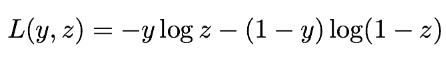

Здесь через y обозначен истинный ответ, через z — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

### План работы
<ul>
    <li>работать с градиентным бустингом и подбирать его гиперпараметры</li>
    <li>сравнивать разные способы построения композиций</li>
    <li>понимать, в каком случае лучше использовать случайный лес, а в каком — градиентный бустинг</li>
    <li>использовать метрику log-loss</li>
</ul>

### Подключение библиотек

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

### Загрузка данных 

In [9]:
data = pd.read_csv('data/week_5_gbm-data.csv')

### Описание данных
Набор текстов с классами




### Инструкции по выполнению
В пакете **scikit-learn** градиентный бустинг реализован в модуле `ensemble` в виде классов `GradientBoostingClassifier` и `GradientBoostingRegressor`. Основные параметры, которые будут интересовать нас: **n_estimators**, **learning_rate**. Иногда может быть полезен параметр **verbose** для отслеживания процесса обучения.

Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод `staged_decision_function`. Для заданной выборки он возвращает ответ на каждой итерации.

Помимо алгоритмов машинного обучения, в пакете **scikit-learn** представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией `train_test_split` модуля `cross_validation`. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные X и y, где X — это признаковое описание объектов, y — целевое значение. 


Метрика `log-loss` реализована в пакете **metrics**: `sklearn.metrics.log_loss`. Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод predict_proba


Метод `predict_proba` возвращает матрицу, i-й столбец которой содержит оценки принадлежности i-му классу.

#### 1. Загрузите выборку 
из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.

In [10]:
X = data.to_numpy()[:,1:]
y = data.to_numpy()[:,0] 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.8,
                                                   random_state=241)

#### 2. Обучите GradientBoostingClassifier 
с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:<br>
Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.<br>
Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.<br>
Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.<br>


In [11]:
def plotting(test, train, i):
    fig = plt.figure()
    plt.title(f'learning rate {i}')
    plt.plot(test, 'r', linewidth=2)
    plt.plot(train, 'b', linewidth=2)
    plt.legend(['test', 'train'])
    plt.show()

Wall time: 0 ns


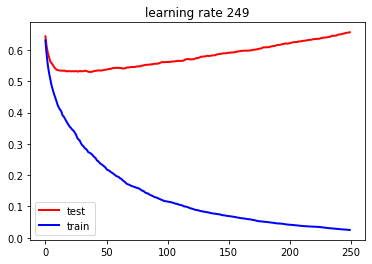

In [12]:
%time
gbc = GradientBoostingClassifier(n_estimators=250, random_state=241, learning_rate=0.2)
gbc.fit(X_train, y_train)
train_qual = []
for j in gbc.staged_decision_function(X_train):
    train_qual.append(log_loss(y_train, 1/(1+np.exp(-j))))    

    
ind = 0  
for i, j in enumerate(train_qual):
    if train_qual[ind] > j:
        ind = i
        
        
test_qual = []
for j in gbc.staged_decision_function(X_test):
    test_qual.append(log_loss(y_test, 1/(1+np.exp(-j))))
plotting(test_qual, train_qual, i)

#### 3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)?

**Overfitting** По графику можно видеть, что хотя на обучающей выборке качество возрастает, на тестовой выборке после примерно 50 итерации качество начинает убывать.

#### 4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [13]:
test_qual[ind], ind

(0.6570034958016724, 249)

#### 5. На этих же данных обучите RandomForestClassifier 
с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba.

In [14]:
forest = RandomForestClassifier(n_estimators=37, random_state=241, n_jobs=-1)
forest.fit(X_train, y_train)

log_loss(y_test,forest.predict_proba(X_test))

0.5410941951182815

#### NOTE: 
Обратите внимание, что, хотя в градиентного бустинге гораздо более слабые базовые алгоритмы, он выигрывает у случайного леса благодаря более "направленной" настройке — каждый следующий алгоритм исправляет ошибки имеющейся композиции. Также он обучается быстрее случайного леса благодаря использованию неглубоких деревьев. В то же время, случайный лес может показать более высокое качество при неограниченных ресурсах — так, он выиграет у градиентного бустинга на наших данных, если увеличить число деревьев до нескольких сотен (проверьте сами!).